In [ ]:
!pip install pydot
!pip install graphviz

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# # import pydot
# import graphviz
# from tf_keras_vis.utils import model_modifier
# from tf_keras_vis.activation_maximization import ActivationMaximization
# from tf_keras_vis.utils.callbacks import Print


In [24]:
data = np.load('images_label_dataset.npz', allow_pickle=True)
images = data['images']
labels = data['labels']
label_binarizer = LabelBinarizer()
one_hot_labels = label_binarizer.fit_transform(labels) 

X_train, x_val, Y_train, y_val = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)  # 60% training, 20% validation, 20% test

print('Train images shape:', x_train.shape)
print('Validation images shape:', x_val.shape)
print('Test images shape:', x_test.shape)


Train images shape: (284889, 32, 32, 3)
Validation images shape: (94964, 32, 32, 3)
Test images shape: (94964, 32, 32, 3)


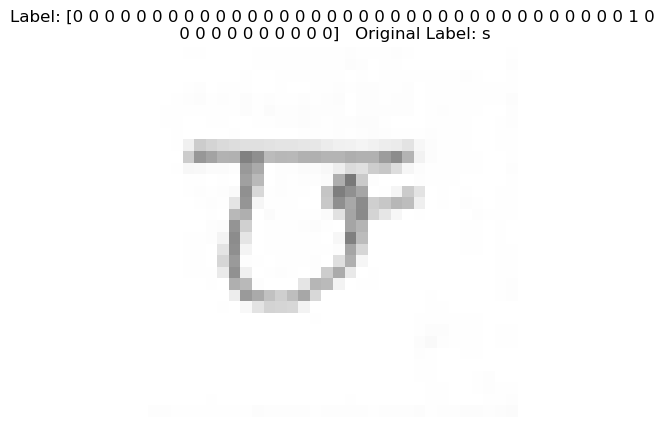

In [25]:
random_index = np.random.randint(0, len(x_val))
selected_image = x_val[random_index]
selected_label_one_hot = y_val[random_index]

selected_label_one_hot = selected_label_one_hot.reshape(1, -1)

original_label = label_binarizer.inverse_transform(selected_label_one_hot)

plt.imshow(selected_image)  
plt.title(f'Label: {y_val[random_index]}   Original Label: {original_label[0]}')
plt.axis('off')
plt.savefig('Images/Sample.png')
plt.show()

## Model 1

In [27]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')
])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learningRate = LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
print('Train images shape:', x_train.shape)
model.summary()

Train images shape: (284889, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normaliz

In [ ]:
plot_model(model, to_file='Images/model1_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose=1)
history = model.fit(x_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val, y_val), callbacks = [early_stopping])#[learningRate, early_stopping])

model.evaluate(x_test, y_test)

Epoch 1/20
8903/8903 [==============================] - 195s 22ms/step - loss: 1.7665 - accuracy: 0.4639 - precision_1: 0.7998 - recall_1: 0.3381 - val_loss: 50.4451 - val_accuracy: 0.0866 - val_precision_1: 0.0869 - val_recall_1: 0.0858
Epoch 2/20
8903/8903 [==============================] - 193s 22ms/step - loss: 0.6815 - accuracy: 0.7930 - precision_1: 0.8766 - recall_1: 0.7247 - val_loss: 11.8496 - val_accuracy: 0.2343 - val_precision_1: 0.2369 - val_recall_1: 0.2208
Epoch 3/20
8903/8903 [==============================] - 194s 22ms/step - loss: 0.5669 - accuracy: 0.8339 - precision_1: 0.8982 - recall_1: 0.7823 - val_loss: 0.3826 - val_accuracy: 0.8889 - val_precision_1: 0.9357 - val_recall_1: 0.8496
Epoch 4/20
8903/8903 [==============================] - 193s 22ms/step - loss: 0.5192 - accuracy: 0.8489 - precision_1: 0.9069 - recall_1: 0.8037 - val_loss: 2.3572 - val_accuracy: 0.6578 - val_precision_1: 0.7169 - val_recall_1: 0.6274
Epoch 5/20
8903/8903 [============================

[0.39508679509162903,
 0.8896529078483582,
 0.927304744720459,
 0.8655911684036255]

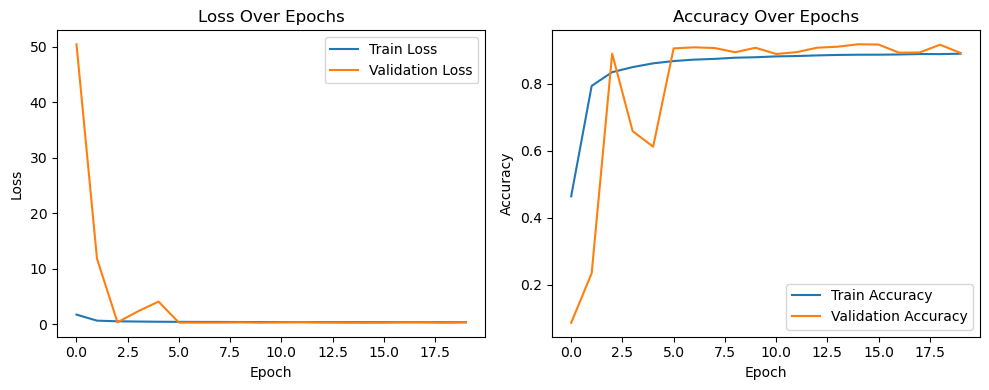

In [29]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Images/model1_loss_accuracy.png')
plt.show()


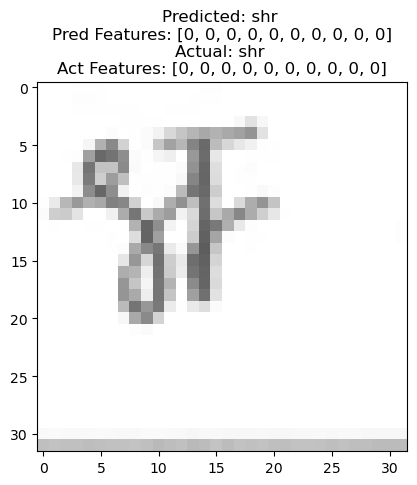

In [28]:
features_df = pd.read_csv('feature_list.csv')
features_dict = features_df.set_index('character').T.to_dict('list')

predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
predicted_label_names = label_binarizer.inverse_transform(predictions)
predicted_features = [features_dict[label] for label in predicted_label_names]

actual_label_names = label_binarizer.inverse_transform(y_test)
actual_features = [features_dict[label] for label in actual_label_names]

index = np.random.randint(0, len(x_test))
plt.imshow(x_test[index])
predicted_info = f"Predicted: {predicted_label_names[index]} \nPred Features: {predicted_features[index]}"
actual_info = f"Actual: {actual_label_names[index]} \nAct Features: {actual_features[index]}"
plt.title(predicted_info + "\n" + actual_info)
plt.savefig('Images/model1_prediction.png')
plt.show()

In [26]:
model.save('custom_cnn_model_1') 

model = load_model('custom_cnn_model_1')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 128)      

2024-05-01 19:32:43.927059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


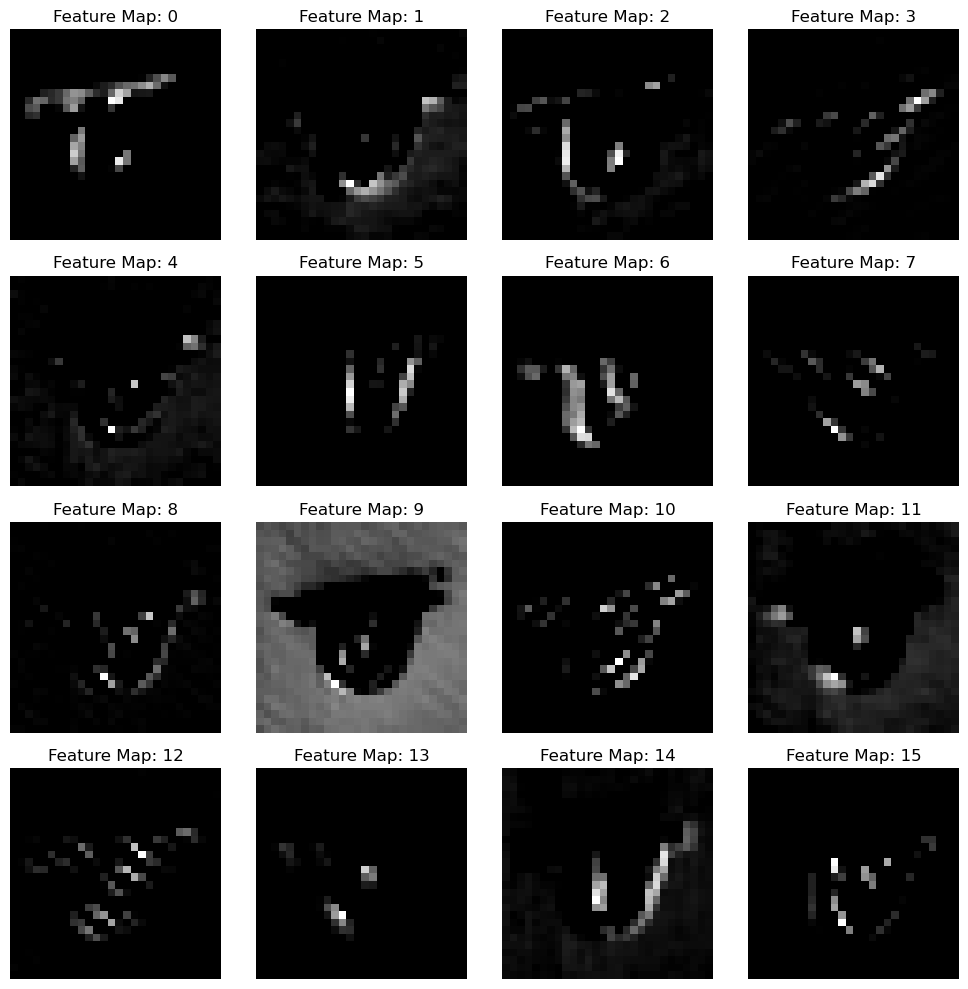

In [7]:
layer = model.layers
layer_name = layer[2].name
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test[:10], batch_size=8)

plt.figure(figsize=(10, 10))
num_maps_to_visualize = min(16, intermediate_output.shape[3])  # Safe check if fewer than 16 filters
for i in range(num_maps_to_visualize):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='gray')  
    plt.title(f'Feature Map: {i}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/model1_featureExtraction.png')
plt.show()

## Model 2 combined

In [2]:
data = np.load('images_label_dataset_combined.npz', allow_pickle=True)
images = data['images']
labels = data['labels']
label_binarizer = LabelBinarizer()
one_hot_labels = label_binarizer.fit_transform(labels) 

X_train, x_val, Y_train, y_val = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)  # 60% training, 20% validation, 20% test

print('Train images shape:', x_train.shape)
print('Validation images shape:', x_val.shape)
print('Test images shape:', x_test.shape)


Train images shape: (328089, 32, 32, 3)
Validation images shape: (109364, 32, 32, 3)
Test images shape: (109364, 32, 32, 3)


In [3]:
# Build the model
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')
])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learningRate = LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model2.compile(optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
print('Train images shape:', x_train.shape)
model2.summary()

2024-05-01 21:18:32.462941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2024-05-01 21:18:32.462973: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-01 21:18:32.463041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c3618.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2024-05-01 21:18:32.483777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train images shape: (328089, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalizat

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose=1)
history2 = model2.fit(x_train, y_train, epochs=20, batch_size=64, 
                    validation_data=(x_val, y_val), callbacks = [learningRate, early_stopping])

model2.evaluate(x_test, y_test)

2024-05-01 21:18:35.040352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
5127/5127 [==============================] - 211s 41ms/step - loss: 1.7226 - accuracy: 0.4768 - precision: 0.7984 - recall: 0.3438 - val_loss: 10.9531 - val_accuracy: 0.1992 - val_precision: 0.1935 - val_recall: 0.1558
Epoch 2/20
5127/5127 [==============================] - 209s 41ms/step - loss: 0.8449 - accuracy: 0.7393 - precision: 0.8659 - recall: 0.6559 - val_loss: 1.7108 - val_accuracy: 0.6069 - val_precision: 0.7677 - val_recall: 0.4920
Epoch 3/20
5127/5127 [==============================] - 208s 41ms/step - loss: 0.6816 - accuracy: 0.7918 - precision: 0.8818 - recall: 0.7251 - val_loss: 0.4169 - val_accuracy: 0.8750 - val_precision: 0.9263 - val_recall: 0.8280
Epoch 4/20
5127/5127 [==============================] - 207s 40ms/step - loss: 0.6098 - accuracy: 0.8168 - precision: 0.8911 - recall: 0.7601 - val_loss: 5.0423 - val_accuracy: 0.4170 - val_precision: 0.5448 - val_recall: 0.3872
Epoch 5/20
5127/5127 [==============================] - 207s 40ms/step - loss: 0.56

[0.38304510712623596,
 0.9023170471191406,
 0.9254667162895203,
 0.8866080045700073]

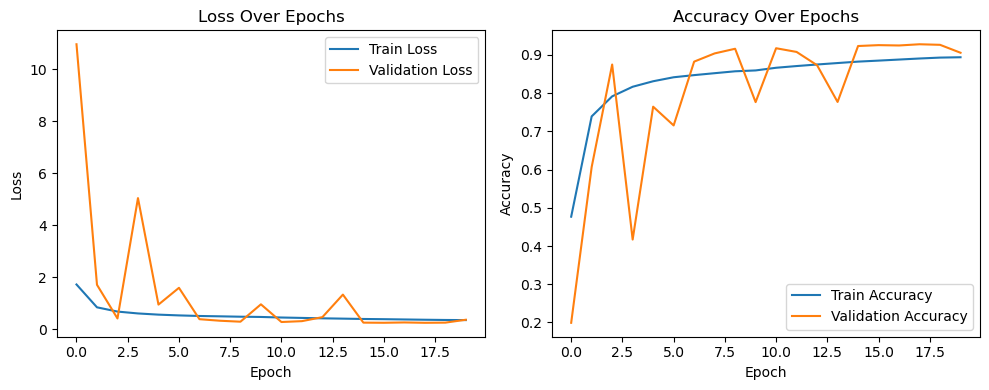

In [5]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Images/model2_loss_accuracy.png')
plt.show()


/tmp/ipykernel_3721364/2229955495.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  features_dict2 = features_df2.set_index('character').T.to_dict('list')
/tmp/ipykernel_3721364/2229955495.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  script_dict2 = features_df2.set_index('Script').T.to_dict('list')


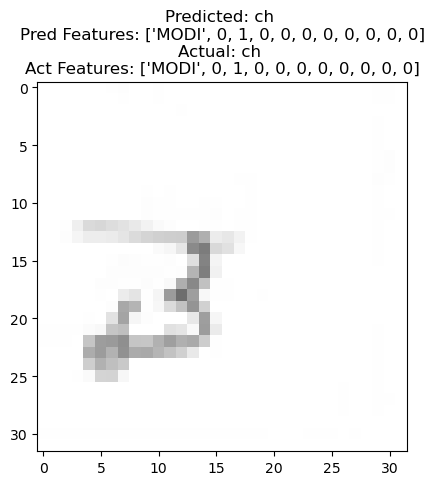

In [16]:
features_df2 = pd.read_csv('feature_list_combined.csv')
features_dict2 = features_df2.set_index('character').T.to_dict('list')
script_dict2 = features_df2.set_index('Script').T.to_dict('list')

predictions2 = model2.predict(x_test)
predicted_labels2 = np.argmax(predictions2, axis=1)
predicted_label_names2 = label_binarizer.inverse_transform(predictions2)
predicted_features2 = [features_dict2[label] for label in predicted_label_names2]

actual_label_names2 = label_binarizer.inverse_transform(y_test)
actual_features2 = [features_dict2[label] for label in actual_label_names2]

index = np.random.randint(0, len(x_test))
plt.imshow(x_test[index])
predicted_info2 = f"Predicted: {predicted_label_names2[index]} \nPred Features: {predicted_features2[index]}"
actual_info2 = f"Actual: {actual_label_names2[index]} \nAct Features: {actual_features2[index]}"
plt.title(predicted_info2 + "\n" + actual_info2)
plt.savefig('Images/model2_prediction.png')
plt.show()

In [13]:
model2.save('custom_cnn_model_2')  

model2 = load_model('custom_cnn_model_2')
model2.summary()

2024-05-01 22:40:46.295287: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: custom_cnn_model_2/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_____________________________________________________________

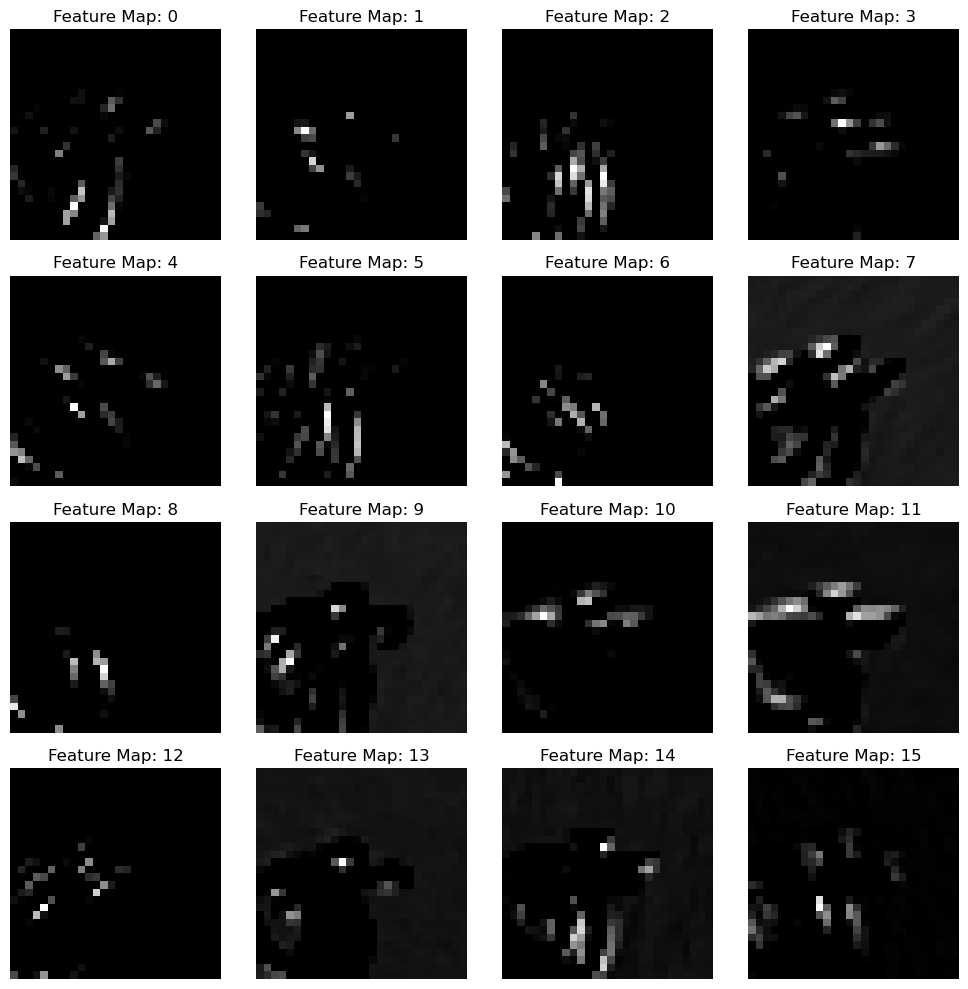

In [15]:
layer = model2.layers
layer_name = layer[2].name
intermediate_layer_model2 = Model(inputs=model2.input,
                                 outputs=model2.get_layer(layer_name).output)
intermediate_output2 = intermediate_layer_model2.predict(x_test[:10], batch_size=8)

plt.figure(figsize=(10, 10))
num_maps_to_visualize = min(16, intermediate_output2.shape[3])  # Safe check if fewer than 16 filters
for i in range(num_maps_to_visualize):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(intermediate_output2[0, :, :, i], cmap='gray')  
    plt.title(f'Feature Map: {i}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/model2_featureExtraction.png')
plt.show()

In [ ]:
# from tf_keras_vis.utils import model_modifier
# from tf_keras_vis.activation_maximization import ActivationMaximization
# from tf_keras_vis.utils.callbacks import Print

# # Create model modifier function to replace all ReLU activations with Softplus activations
# @model_modifier
# def model_modifier_function(model):
#     model.layers[-1].activation = tf.keras.activations.linear
#     return model

# # Create ActivationMaximization object
# activation_maximization = ActivationMaximization(model, model_modifier=model_modifier_function, clone=False)

# # Define callback functions
# callbacks = [
#     Print(interval=50)
# ]

# # Generate activation maximization image for a specific filter in a specific layer
# layer_name = 'conv2d_14'  # Specify your layer
# filter_index = 10  # Specify filter index
# img = activation_maximization(loss=lambda output: output[..., filter_index], callbacks=callbacks)

# plt.imshow(img)
# plt.title(f'Maximally Activated Input for Filter {filter_index} in {layer_name}')
# plt.show()
